In [1]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

df = pd.read_excel("fraud_detection.xlsx")
print("Data loaded successfully.")
print(df.head())


Data loaded successfully.
   step     type          branch   amount     nameOrig  oldbalanceOrg  \
0     7  PAYMENT          Espana  1526.50  C1908839976            0.0   
1     7  PAYMENT        Honduras  1620.17    C70432899            0.0   
2     7  PAYMENT       Indonesia  5689.82   C332151172            0.0   
3     7  PAYMENT  Estados Unidos  2211.07  C1148172078            0.0   
4     7  PAYMENT  Estados Unidos   824.63  C1142006014            0.0   

   newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  unusuallogin  \
0             0.0  M1304522697             0.0             0.0             7   
1             0.0   M252297858             0.0             0.0             2   
2             0.0  M1430674428             0.0             0.0             3   
3             0.0   M650835126             0.0             0.0            13   
4             0.0   M745868137             0.0             0.0             7   

   isFlaggedFraud Acct type Date of transaction Time o

DATA EXPLORATION AND CLEANING

In [2]:

print("\nDataset info:")
df.info()

print("\nSummary statistics:")
print(df.describe())

numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nMean values:")
print(df[numeric_cols].mean())

print("\nMedian values:")
print(df[numeric_cols].median())

print("\nMode values:")
print(df[numeric_cols].mode().iloc[0])

print("\nVariance values:")
print(df[numeric_cols].var())

print("\nStandard Deviation values:")
print(df[numeric_cols].std())

corr_matrix = df[numeric_cols].corr()
print("\nCorrelation matrix:")
print(corr_matrix)

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDuplicate rows count:")
print(df.duplicated().sum())

df = df.drop_duplicates()

print("\nRandom sample of dataset:")
print(df.sample(5))



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   step                 10127 non-null  int64         
 1   type                 10123 non-null  object        
 2   branch               10127 non-null  object        
 3   amount               10125 non-null  float64       
 4   nameOrig             10121 non-null  object        
 5   oldbalanceOrg        10125 non-null  float64       
 6   newbalanceOrig       10127 non-null  float64       
 7   nameDest             10121 non-null  object        
 8   oldbalanceDest       10126 non-null  float64       
 9   newbalanceDest       10125 non-null  float64       
 10  unusuallogin         10127 non-null  int64         
 11  isFlaggedFraud       10127 non-null  int64         
 12  Acct type            10117 non-null  object        
 13  Date of transact

EDA

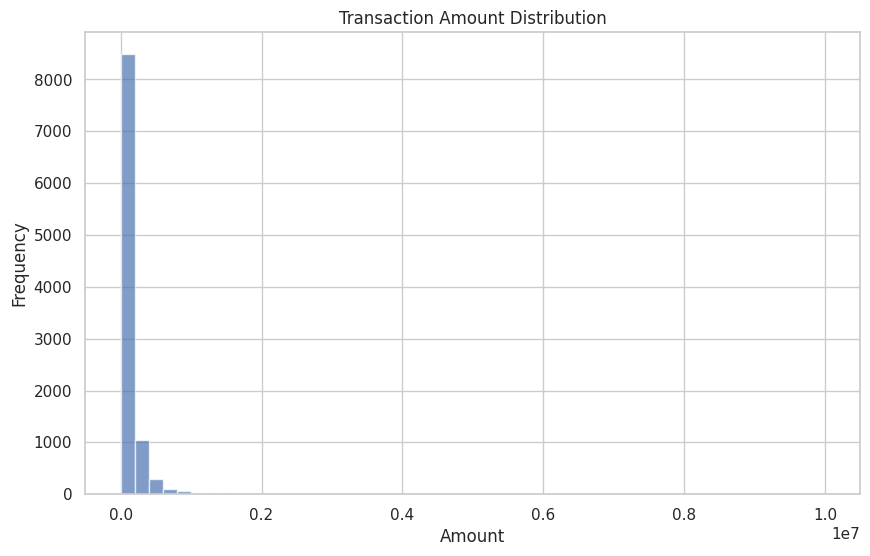

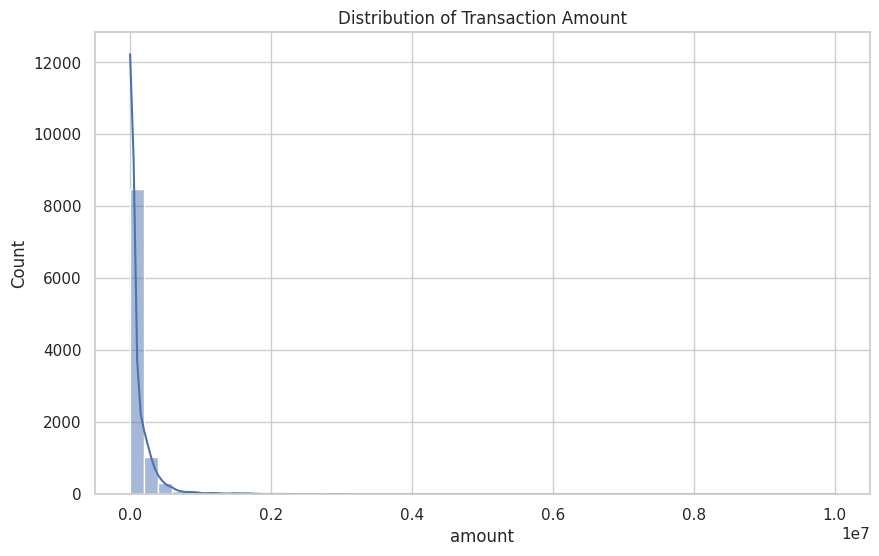

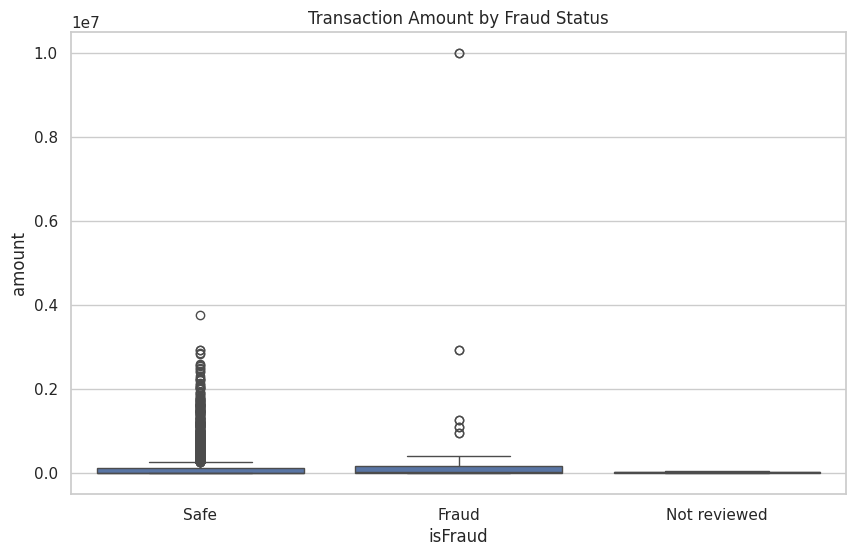

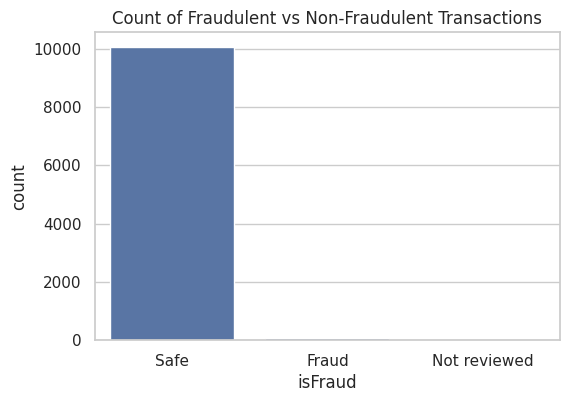

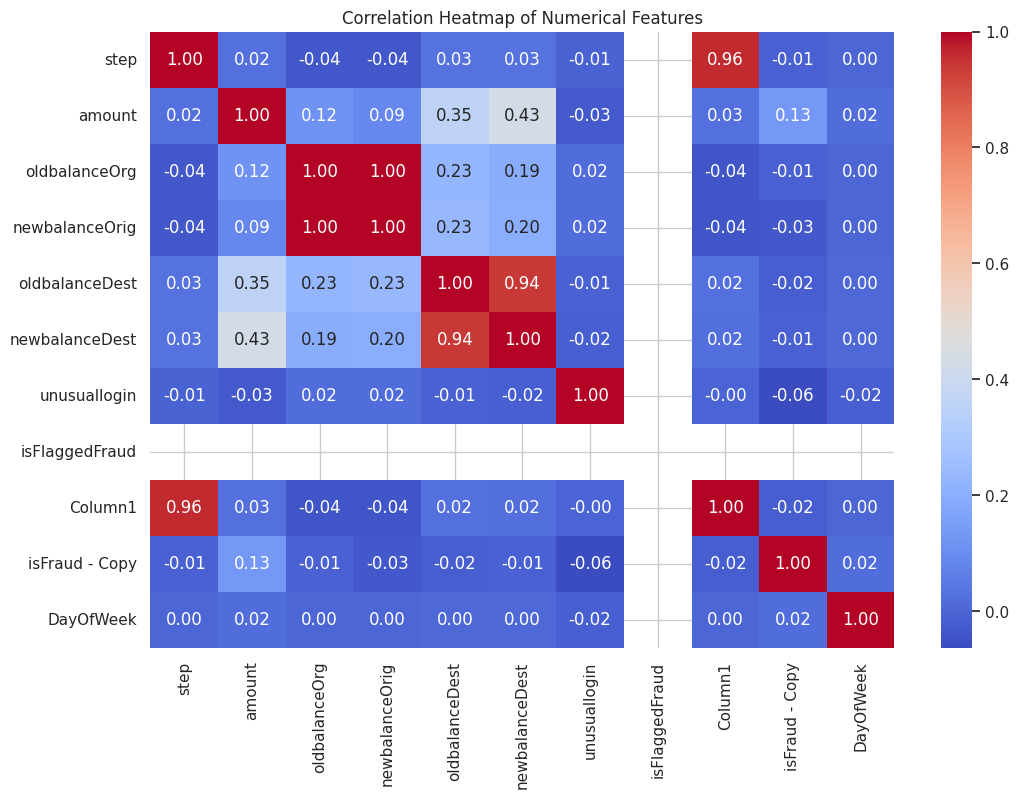

In [3]:

plt.figure(figsize=(10, 6))
plt.hist(df['amount'], bins=50, alpha=0.7)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['amount'], kde=True, bins=50)
plt.title('Distribution of Transaction Amount')
plt.show()

if 'isFraud' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='isFraud', y='amount', data=df)
    plt.title('Transaction Amount by Fraud Status')
    plt.show()

if 'isFraud' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='isFraud', data=df)
    plt.title('Count of Fraudulent vs Non-Fraudulent Transactions')
    plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


DIMENSIONALITY REDUCTION

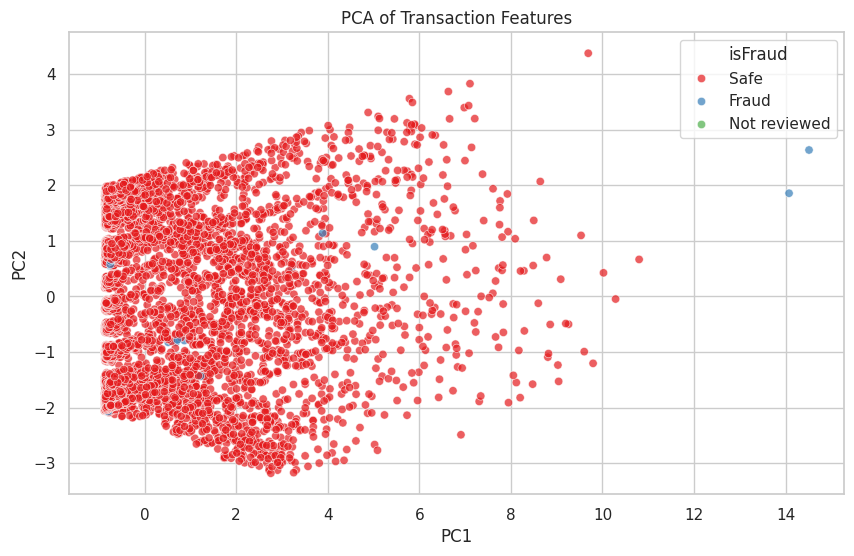

In [4]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feature_cols = numeric_cols.drop(['isFraud'], errors='ignore')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols].fillna(0))

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
if 'isFraud' in df.columns:
    pca_df['isFraud'] = df['isFraud'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='isFraud', data=pca_df, palette='Set1', alpha=0.7)
plt.title('PCA of Transaction Features')
plt.show()


DATA PREPROCESSING

In [6]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

target = 'isFraud'
features = feature_cols.tolist()

df[features] = df[features].fillna(0)

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed.")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Data preprocessing completed.
Training samples: 7595, Test samples: 2532


Training Logistic Regression...
Logistic Regression training completed.



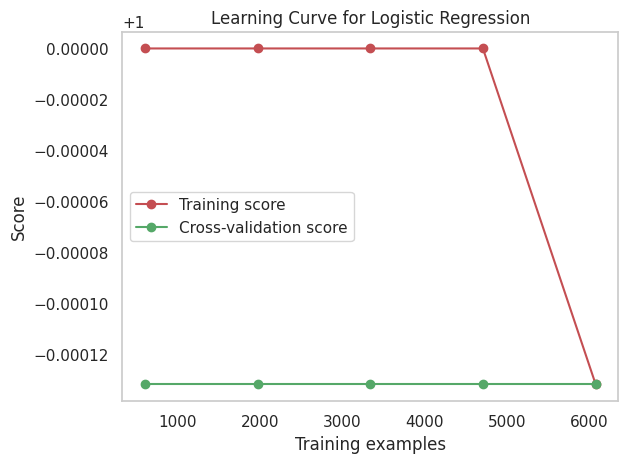

Training Random Forest...
Random Forest training completed.



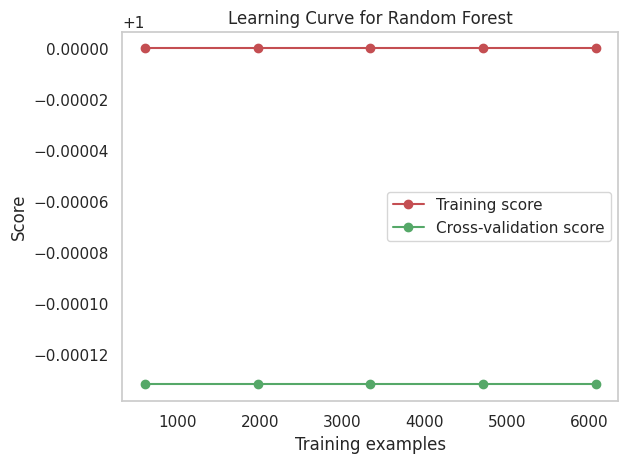

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=200),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
}

trained_models = {}

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()


for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"{name} training completed.\n")

    plot_learning_curve(model, f"Learning Curve for {name}", X_train_scaled, y_train)


MODEL EVALUATION


In [8]:
for name, model in trained_models.items():
    print(f"Evaluating {name}...")

    y_pred = model.predict(X_test_scaled)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_scaled)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    else:
        roc_auc = 'N/A'
    print(f"\nClassification Report for {name}:\n", classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc if roc_auc == 'N/A' else roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("-" * 50)


Evaluating Logistic Regression...

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

       Fraud       1.00      1.00      1.00        17
Not reviewed       0.00      0.00      0.00         1
        Safe       1.00      1.00      1.00      2514

    accuracy                           1.00      2532
   macro avg       0.67      0.67      0.67      2532
weighted avg       1.00      1.00      1.00      2532

Accuracy: 0.9996
Precision: 0.9992
Recall: 0.9996
F1 Score: 0.9994
ROC AUC: 0.9980
Confusion Matrix:
[[  17    0    0]
 [   0    0    1]
 [   0    0 2514]]
--------------------------------------------------
Evaluating Random Forest...

Classification Report for Random Forest:
               precision    recall  f1-score   support

       Fraud       1.00      1.00      1.00        17
Not reviewed       0.00      0.00      0.00         1
        Safe       1.00      1.00      1.00      2514

    accuracy                           1

In [9]:
import pickle

best_model = trained_models['Random Forest']

model_pkl_filename = 'fraud_detection_rf_model.pkl'
with open(model_pkl_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model saved to {model_pkl_filename}")

features_pkl_filename = 'feature_columns.pkl'
with open(features_pkl_filename, 'wb') as f:
    pickle.dump(features, f)
print(f"Feature columns saved to {features_pkl_filename}")


Model saved to fraud_detection_rf_model.pkl
Feature columns saved to feature_columns.pkl


NEW DATA

In [11]:
import numpy as np
import pandas as pd

new_df = pd.read_excel("prediction_data.xlsx")

columns_to_drop = ['isFraud', 'Predicted_isFraud', 'Fraud_Probability']
new_df = new_df.drop(columns=[col for col in columns_to_drop if col in new_df.columns])

new_X = new_df[features].fillna(0)

categorical_features = new_X.select_dtypes(include=['object']).columns

new_X_encoded = pd.get_dummies(new_X, columns=categorical_features)

missing_cols = set(features) - set(new_X_encoded.columns)
for col in missing_cols:
    new_X_encoded[col] = 0

new_X_encoded = new_X_encoded[features]

new_X_scaled = scaler.transform(new_X_encoded)

best_model = trained_models['Random Forest']

prob_matrix = best_model.predict_proba(new_X_scaled)

predictions = best_model.predict(new_X_scaled)

fraud_probabilities = []
for pred, probs in zip(predictions, prob_matrix):
    class_index = list(best_model.classes_).index(pred)
    fraud_probabilities.append(probs[class_index])

fraud_probabilities = np.array(fraud_probabilities)

new_df['Predicted_isFraud'] = predictions
new_df['Fraud_Probability'] = fraud_probabilities

output_file = 'fraud_predictions.xlsx'
new_df.to_excel(output_file, index=False)

print(f"Predictions saved to '{output_file}'.")


Predictions saved to 'fraud_predictions.xlsx'.
